### **Finding similar Medium articles**

You are working as a Data Scientist at Medium

* **Medium** is an online publishing platform which hosts a hybrid collection of blog posts from both amateur and professional people and publications.
* In 2020, about 47,000 articles were published daily on the platform and it had about 200M visitors every month.

#### **Problem Statement:**

* You want to give readers a better reading experience at Medium. To do that, you want to recommend articles to the user on the basis of the current article that the user is reading.
* More concretely, given a Medium article find a set of similar articles.

**How would a human find similar articles in a corpus ?**

1.  Look at the title - find similar titles.
2.  Find articles by the same author.
3.  Go through the text, understand it and group the articles within broader topics.

In [28]:
# Libraries to display dataframe and images
from IPython.display import display
from PIL import Image

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling libraries
import pandas as pd
import numpy as np

# Text processing libraries
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# Pretty printing
from pprint import pprint

# Statistical analysis
from scipy.stats import pearsonr

In [29]:
# Setting up the NLTK for preprocessing textual data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')
nltk.download('treebank')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already u

True

In [30]:
# Configuring Seaborn and Pandas display settings
sns.set_theme(style='darkgrid')
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [31]:
# Load the dataset
articles = pd.read_csv(r"medium_articles_v3.csv")

# Display the first 10 rows and shape of the dataframe
display(articles.head(10))
print("Shape of dataframe : {}".format(articles.shape))

,link,title,sub_title,author,reading_time,text,id
0,https://towardsdatascience.com/ensemble-method...,"Ensemble methods: bagging, boosting and stacking",Understanding the key concepts of ensemble lea...,Joseph Rocca,20,This post was co-written with Baptiste Rocca.\...,1
1,https://towardsdatascience.com/understanding-a...,Understanding AUC - ROC Curve,"In Machine Learning, performance measurement i...",Sarang Narkhede,5,"In Machine Learning, performance measurement i...",2
2,https://towardsdatascience.com/how-to-work-wit...,How to work with object detection datasets in ...,"A comprehensive guide to defining, loading, ex...",Eric Hofesmann,10,Microsoft's Common Objects in Context dataset ...,3
3,https://towardsdatascience.com/11-dimensionali...,11 Dimensionality reduction techniques you sho...,Reduce the size of your dataset while keeping ...,Rukshan Pramoditha,16,"In both Statistics and Machine Learning, the n...",4
4,https://towardsdatascience.com/the-time-series...,The Time Series Transformer,Attention Is All You Need they said. Is it a m...,Theodoros Ntakouris,6,Attention Is All You Need they said. Is it a m...,5
5,https://netflixtechblog.com/learning-a-persona...,Learning a Personalized Homepage,how to best tailor each member's homepage to m...,Netflix Technology Blog,15,by Chris Alvino and Justin Basilico\nAs we've ...,6
6,https://towardsdatascience.com/6-data-science-...,6 Data Science Certificates To Level Up Your C...,Pump up your portfolio and get closer to your ...,Sara A. Metwalli,6,Because of the appeal of the field of data sci...,7
7,https://towardsdatascience.com/transformers-ex...,Transformers Explained Visually (Part 2): How ...,A Gentle Guide to the Transformer under the ho...,Ketan Doshi,11,This is the second article in my series on Tra...,8
8,https://medium.com/coders-camp/60-python-proje...,60 Python Projects with Source Code,60 Python Projects with Source code solved and...,Aman Kharwal,2,Python has been in the top 10 popular programm...,9
9,https://towardsdatascience.com/geometric-found...,Geometric foundations of Deep Learning,Geometric Deep Learning is an attempt to unify...,Michael Bronstein,13,This blog post was co-authored with Joan Bruna...,10


Shape of dataframe : (208, 7)


In [32]:
articles.columns

Index(['link', 'title', 'sub_title', 'author', 'reading_time', 'text', 'id'], dtype='object')

In [33]:
# # Install datasets if not already installed
# !uv pip install datasets

# # Load dataset from Hugging Face
# from datasets import load_dataset

# dataset = load_dataset("fabiochiu/medium-articles")
# train_data = dataset['train']

# # Display the first example
# print(train_data[0])

# # Save to local directory (optional)
# dataset.save_to_disk("path_to_directory")

# # Load from local directory (optional)
# from datasets import load_from_disk
# dataset = load_from_disk("path_to_directory")

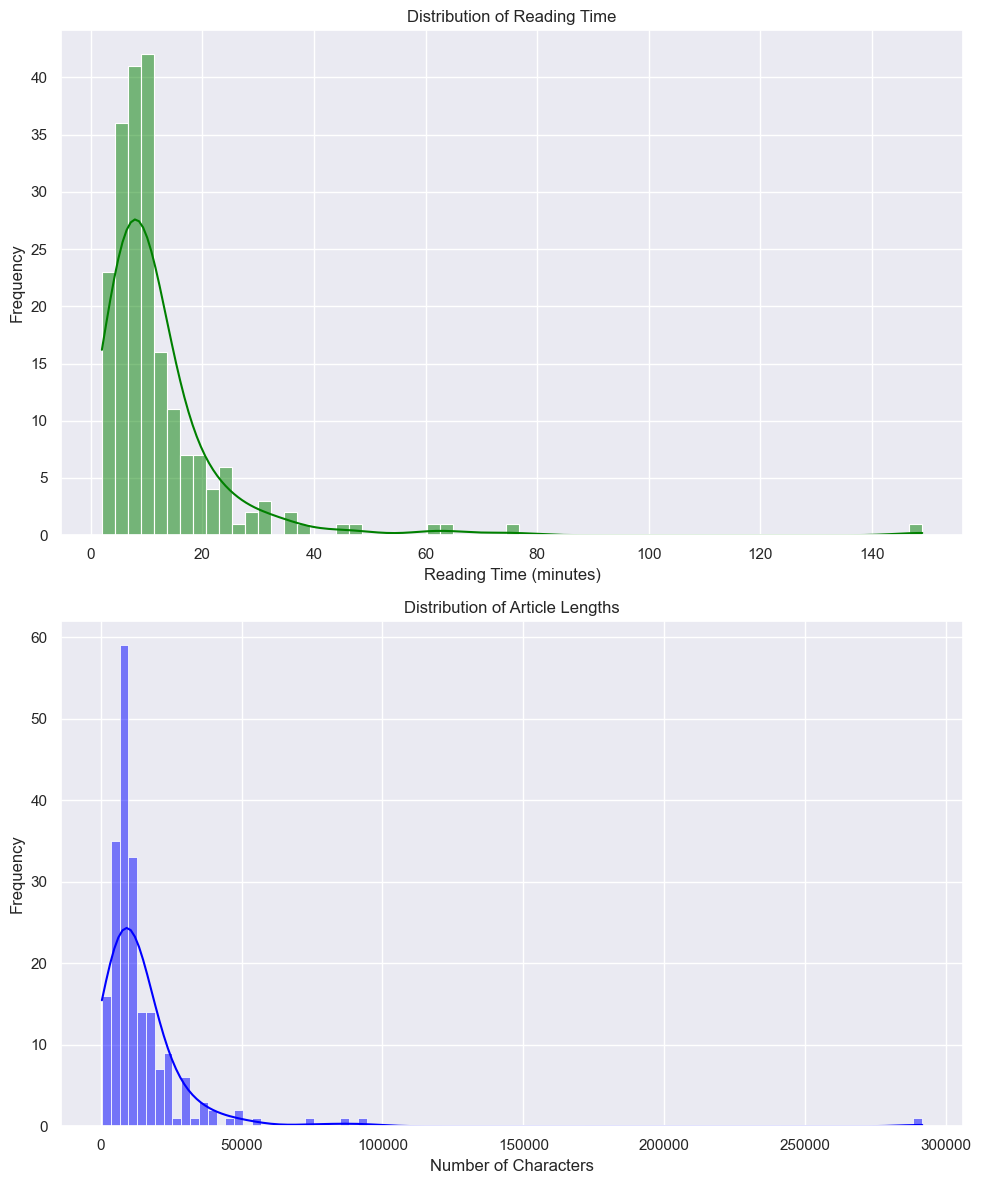

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Recalculate article length in case it's not already done
articles['article_length'] = articles['text'].str.len()

# Create subplots for numerical distributions
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plotting the distribution of 'reading_time'
sns.histplot(data=articles, x='reading_time', kde=True, ax=axes[0], color='green')
axes[0].set_title('Distribution of Reading Time')
axes[0].set_xlabel('Reading Time (minutes)')
axes[0].set_ylabel('Frequency')

# Plotting the distribution of 'article_length'
sns.histplot(data=articles, x='article_length', kde=True, ax=axes[1], color='blue')
axes[1].set_title('Distribution of Article Lengths')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


Index(['link', 'title', 'sub_title', 'author', 'reading_time', 'text', 'id',
       'article_length'],
      dtype='object')


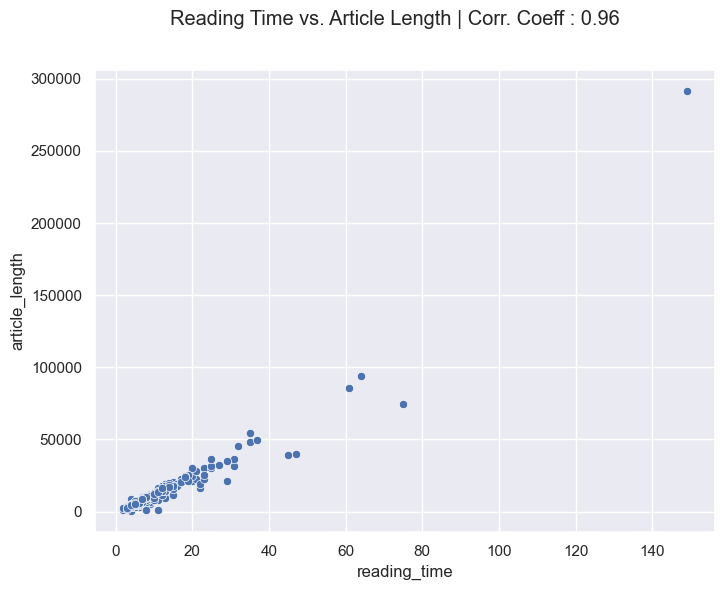

In [35]:
print(articles.columns)

if 'text' in articles.columns:
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(x=articles["reading_time"], y=articles["article_length"])
    corr_coeff, _ = pearsonr(articles["reading_time"], articles["article_length"])
    plt.suptitle(f"Reading Time vs. Article Length | Corr. Coeff : {corr_coeff:.2f}")
    plt.show()
else:
    print("Warning: 'text' column not found in the dataset. Please use the correct dataset with article text.")

- The graph is clearly right skewed.
- Hence most of articles in our corpus have a less reading time, with some articles having reading in hours.

* Based on the scatter plot, there is a strong positive correlation (0.96) between reading time and article length

In [39]:
# Drop the duplicate article_len column
# articles = articles.drop('article_len', axis=1)

In [ ]:
from pprint import pprint

pprint(articles.iloc[1].to_dict(), compact=True)

{'article_length': 4322,
 'author': 'Sarang Narkhede',
 'id': 2,
 'link': 'https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5?source=tag_archive---------1-----------------------',
 'reading_time': 5,
 'sub_title': 'In Machine Learning, performance measurement is an essential '
              'task. So when it comes to a classification problem, we can '
              'count on an AUC - ROC Curve. When we need to check or visualize '
              'the performance...',
 'text': 'In Machine Learning, performance measurement is an essential task. '
         'So when it comes to a classification problem, we can count on an AUC '
         '- ROC Curve. When we need to check or visualize the performance of '
         'the multi-class classification problem, we use the AUC (Area Under '
         'The Curve) ROC (Receiver Operating Characteristics) curve. It is one '
         'of the most important evaluation metrics for checking any '
         "classification model's perfor

In [40]:
articles.describe(include='all')

,link,title,sub_title,author,reading_time,text,id,article_length
count,208,208,208,208,208.000000,208,208.000000,208.000000
unique,208,208,204,179,NaN,208,NaN,NaN
top,https://towardsdatascience.com/ensemble-method...,"Ensemble methods: bagging, boosting and stacking",Update: This article is part of a series. Chec...,Adam Geitgey,NaN,This post was co-written with Baptiste Rocca.\...,NaN,NaN
freq,1,1,4,5,NaN,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,12.375000,NaN,107.091346,14729.394231
std,NaN,NaN,NaN,NaN,13.880224,NaN,62.575453,23125.910206
min,NaN,NaN,NaN,NaN,2.000000,NaN,1.000000,428.000000
25%,NaN,NaN,NaN,NaN,6.000000,NaN,52.750000,6706.500000
50%,NaN,NaN,NaN,NaN,9.000000,NaN,107.500000,9588.000000
75%,NaN,NaN,NaN,NaN,13.000000,NaN,162.250000,16020.250000


In [41]:
articles.columns

Index(['link', 'title', 'sub_title', 'author', 'reading_time', 'text', 'id',
       'article_length'],
      dtype='object')


* As expected, longer articles take more time to read
* **Do writers usually write articles on similar topics?**
Let's have a look at the authors now. Authors usually have a preference to write on the same topic.


In [43]:
author_counts = articles["author"].value_counts()
for author, count in author_counts.items():
    if count < 2:
        continue
    print(f"Articles by {author} ({count} articles):")
    titles = articles[articles["author"] == author]["title"].values
    for title in titles:
        print(f"- {title}")
    print("-" * 120)

Articles by Adam Geitgey (5 articles):
- Machine Learning is Fun Part 5: Language Translation with Deep Learning and the Magic of Sequences
- Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning
- Machine Learning is Fun! Part 3: Deep Learning and Convolutional Neural Networks
- Machine Learning is Fun! Part 2
- Machine Learning is Fun Part 6: How to do Speech Recognition with Deep Learning
------------------------------------------------------------------------------------------------------------------------
Articles by Joseph Rocca (3 articles):
- Ensemble methods: bagging, boosting and stacking
- Understanding Variational Autoencoders (VAEs)
- Understanding Generative Adversarial Networks (GANs)
------------------------------------------------------------------------------------------------------------------------
Articles by Natassha Selvaraj (3 articles):
- I tripled my income with data science. Here's how.
- How to Land a Data Analytics Job in 6 Months
- To

* In the data that we have, it does seem that authors tend to write multiple articles on the same topic.
* But also, there are multiple authors writing on the same topic,
* For example:
    1. Adam Geitgey & Susan Li, both seems to write on Machine Learning.
    2. Natassha Selvaraj, Sara A. Metwalli & Terence Shin, all seems to write on building career as a Data Scientist.

### **Solving common preprocessing Problems in NLP.**

### **Expanding Word Contractions**

* Contractions are the shortened word of english words or phrases.

    Example -
    ```text
            can't → can not
            you're → you are
            you'll've → you will have
    ```
* Why is this a problem?

    Because of the following reasons -

    1.  They add in a special apostrophe character (computers cannot understand its meaning) to the text.
    2.  They are a combination of two words, hence can cause problems in tokenization.
* How to deal with it ?

    1.  Create a custom mapping of expansions.
    2.  Using contractions library.

In [44]:
import re

# creating custom mapping
custom_mapping = {
    "n't": " not",
    "re": " are",
    "ve": " have",
    "ll": " will",
    "m": " am"
}

# sample data
sample_text = """
I've decided to go to the party after all. I'll reach by 05:00 PM.
He's not coming with us.
It's his birthday and he has other plans.
They've the birthday about going to the movies.
I won't be going to the movies.
"""

In [45]:
expanded_text = sample_text
for x in custom_mapping.keys():
    expanded_text = re.sub(x, custom_mapping[x], expanded_text)

print(expanded_text)


I' have decided to go to the party after a will. I' will  areach by 05:00 PM.
He's not co aming with us.
It's his birthday and he has other plans.
They' have the birthday about going to the  amovies.
I wo not be going to the  amovies.



#### **The problem with above approach**

1.  The number of contractions can be large to list all.
2.  There can be some not so simple cases which breaks the rule, like "won't".

Lets try out second approach.

**Using contractions library:** [Contractions Github](https://www.google.com/search?q=https://github.com/cyberzhg/python-contractions)

In [47]:
%uv pip install contractions

Note: you may need to restart the kernel to use updated packages.


Using Python 3.10.9 environment at: C:\Users\Admin\AppData\Local\Programs\Python\Python310
Resolved 4 packages in 1.85s
Prepared 4 packages in 1.60s
Installed 4 packages in 645ms
 + anyascii==0.3.2
 + contractions==0.1.73
 + pyahocorasick==2.1.0
 + textsearch==0.0.24


In [48]:
import contractions
expanded_text = contractions.fix(sample_text)
print(expanded_text)


I have decided to go to the party after all. I will reach by 05:00 PM.
He is not coming with us.
It is his birthday and he has other plans.
They have the birthday about going to the movies.
I will not be going to the movies.



### **How do we represent text as numbers ?**

* Machine learning algorithms need input data as numbers.
* What we have here is textual data.
* So we need to find a way to convert these texts into numbers (or vectors).
* Imagine each document that we have, is represented as a vector of numbers, of size $N$.

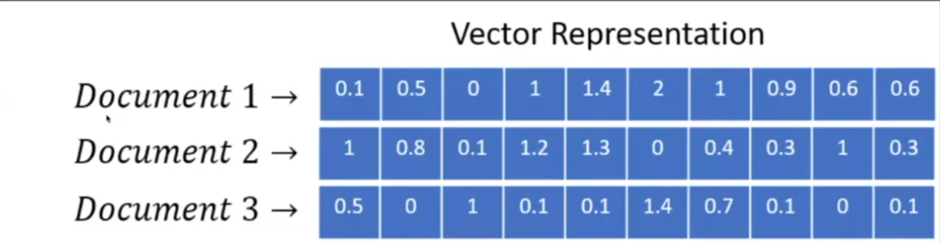

In [49]:
img = Image.open('image.png')
display(img)

* Now once we have vectorized, each document we can use them as features for any machine learning model of our choice.
* There are multiple ways using which we can get a vector representation of text. Let's have a look at a couple of them.

### **What could be the simplest techniques of converting a document into a vector?**

### **One-Hot encoding:**

* Assigns 0 to all elements in a vector except for one, which has a value of 1. This value represents a category of an element.

    For example:
    ```text
    If sentence = "Lecture on text representation"
    ```

### **Step 1 - Create a vocabulary from the above corpus**

Vocabulary is simply a set of all unique words in the documents. For the above example, the vocabulary would be

* Lecture
* on
* text
* representation

### **Step 2 - Each word in the sentence would be represented as below:**

| Word         | Lecture | on | text | representation |
| :----------- | :------: | :-: | :--: | :------------: |
| Lecture      |    1    |  0  |  0   |       0        |
| on           |    0    |  1  |  0   |       0        |
| text         |    0    |  0  |  1   |       0        |
| representation |    0    |  0  |  0   |       1        |

```
Lecture → [1 0 0 0], on → [0 1 0 0], text → [0 0 1 0], representation → [0 0 0 1]
```

### **Step 3 - The entire sentence is then represented as:**

```
sentence = [ [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1] ]
```

* Intuition behind it is that each bit represents a possible category.
* And if a particular variable cannot fall into multiple categories, then a single bit is enough to represent it.

In [51]:
from sklearn.preprocessing import OneHotEncoder
import itertools
import numpy as np

# two example documents
docs = ['cat', 'dog', 'bat', 'ate', 'lion']
tokens_docs = [doc.split(' ') for doc in docs]

# convert list of token-lists to one flat list of tokens
# and then create a dictionary that maps word to id of word,
all_tokens = itertools.chain.from_iterable(tokens_docs)
word_to_id = {token: idx for idx, token in enumerate(set(all_tokens))}

# convert token lists to token-id lists and reshape for OneHotEncoder
token_ids = [[word_to_id[token] for token in tokens_doc] for tokens_doc in tokens_docs]
token_ids_array = np.array(token_ids).reshape(-1, 1)

# convert list of token-id lists to one-hot representation
vec = OneHotEncoder(categories='auto', sparse_output=False)
X = vec.fit_transform(token_ids_array)

print(X)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


### **Drawbacks:**

1.  Cannot measure the importance of a word in a sentence but understand the mere presence/absence of a word in a sentence.
2.  High dimensional sparse matrix representation can be memory & computationally expensive.
3.  Explosion in feature space if the number of categories is very high.
4.  The vector representation of words is orthogonal and cannot determine or measure the relationship between different words.

### **How can we optimize on One Hot Encoding ?**

### **Can we use the frequency of each word in the document ?**

* Puts words in a "bag" & computes the frequency of occurrence of each word.

Let's start with an example. Let us assume that our corpus contains following 3 texts -

1.  It was the best of times
2.  It was the worst of times
3.  It was the age of wisdom and the age of foolishness

### **Step 1 - Create a vocabulary from the above corpus**

Vocabulary is simply a set of all unique words in the documents. For the above example, the vocabulary would be -

* it
* was
* the
* best
* of
* times
* worst
* age
* wisdom
* and
* foolishness

### Step 2 - Construct One Hot Encoded representation of the words

For every sentence in a text, create a OHE representation of it using the vocabulary from Step 1.

For the 1st sentence -

| Word       | it | was | the | best | of | times |
|------------|----|-----|-----|------|----|-------|
| it         | 1  | 0   | 0   | 0    | 0  | 0     |
| was        | 0  | 1   | 0   | 0    | 0  | 0     |
| the        | 0  | 0   | 1   | 0    | 0  | 0     |
| best       | 0  | 0   | 0   | 1    | 0  | 0     |
| of         | 0  | 0   | 0   | 0    | 1  | 0     |
| times      | 0  | 0   | 0   | 0    | 0  | 1     |
| worst      | 0  | 0   | 0   | 0    | 0  | 0     |
| age        | 0  | 0   | 0   | 0    | 0  | 0     |
| wisdom     | 0  | 0   | 0   | 0    | 0  | 0     |
| and        | 0  | 0   | 0   | 0    | 0  | 0     |
| foolishness| 0  | 0   | 0   | 0    | 0  | 0     |


### Step 3 - Combine the OHE word representations for every document

Once we have the OHE of all words in a document, the only thing left is to combine them, to get a single vector representation for the document. There are two common ways to do so:

1. **Using a binary OR operator** between the OHE vectors.  
   The final document vector that we get in this case simply tells the **absence or presence** of certain words in the document.

2. **Using a vector sum operator**.  
   The final document vector that we get in this case tells the **frequency** of each word in the document.


| Word        | it | was | the | age | of | wisdom | and | the | age | of | foolishness | OR | SUM |
|-------------|----|-----|-----|-----|----|--------|-----|-----|-----|----|--------------|----|-----|
| it          | 1  | 0   | 0   | 0   | 0  | 0      | 0   | 0   | 0   | 0  | 0            | 1  | 1   |
| was         | 0  | 1   | 0   | 0   | 0  | 0      | 0   | 0   | 0   | 0  | 0            | 1  | 1   |
| the         | 0  | 0   | 1   | 0   | 0  | 0      | 0   | 1   | 0   | 0  | 0            | 1  | 2   |
| best        | 0  | 0   | 0   | 0   | 0  | 0      | 0   | 0   | 0   | 0  | 0            | 0  | 0   |
| of          | 0  | 0   | 0   | 0   | 1  | 0      | 0   | 0   | 0   | 1  | 0            | 1  | 2   |
| times       | 0  | 0   | 0   | 0   | 0  | 0      | 0   | 0   | 0   | 0  | 0            | 0  | 0   |
| worst       | 0  | 0   | 0   | 0   | 0  | 0      | 0   | 0   | 0   | 0  | 0            | 0  | 0   |
| age         | 0  | 0   | 0   | 1   | 0  | 0      | 0   | 0   | 1   | 0  | 0            | 1  | 2   |
| wisdom      | 0  | 0   | 0   | 0   | 0  | 1      | 0   | 0   | 0   | 0  | 0            | 1  | 1   |
| and         | 0  | 0   | 0   | 0   | 0  | 0      | 1   | 0   | 0   | 0  | 0            | 1  | 1   |
| foolishness | 0  | 0   | 0   | 0   | 0  | 0      | 0   | 0   | 0   | 0  | 1            | 1  | 1   |


Note: The combination using the sum operator is more commonly used, as it conveys more information about the text - like which words are used more frequently (this is obviously done after removing stopwords).

The representation of all the 3 texts above are -

| Sentence                                     | it  | was | the | best | of  | times | worst | age | wisdom | and | foolishness |
|----------------------------------------------|-----|-----|-----|------|-----|-------|-------|-----|--------|-----|-------------|
| It was the best of times                     | 1   | 1   | 1   | 1    | 1   | 0     | 0     | 0   | 0      | 0   | 0           |
| It was the worst of times                    | 1   | 1   | 0   | 1    | 1   | 1     | 0     | 0   | 0      | 0   | 0           |
| It was the age of wisdom and the age of foolishness | 1   | 2   | 0   | 2    | 0   | 0     | 2     | 1   | 1      | 1   | 1           |

* Here, we see that each of 3 documents are represented as a vector of size 11 (vocabulary size).
* This vectorization technique is easy to implement as well. Plus it also has a implementation in the scikit-learn package.

The above representation is called Bag-of-Words (BOW)

BOW is one of the simplest techniques use for textual feature extraction. Here, yet again we break the document into its smallest component - words, and build it from there.

* It does not take into account the word order or lexical information for text representation.
* The intuition is that documents having similar words are similar irrespective of the word positioning.

In [54]:
import pandas as pd
corpus = [
    "it was the best of times",
    "it was the worst of times",
    "it was the age of wisdom and the age of foolishness"
]

def get_bow_representation(corpus, frequency = True):
    vocabulary = set([x for x in " ".join(corpus).lower().split(" ")])
    
    bow_rep = []
    for sentence in corpus:
        sentence_rep = {v: 0 for v in vocabulary}  # Initialize with 0 instead of dict()
        for word in word_tokenize(sentence):
            if frequency:
                sentence_rep[word] += 1
            else:
                sentence_rep[word] = 1
    
        bow_rep.append(sentence_rep)
    return bow_rep

bow_representation = get_bow_representation(corpus, True)
df = pd.DataFrame(bow_representation)
df.index = corpus  # This should work as long as pandas is properly imported
display(df)

,times,worst,and,foolishness,it,of,was,the,wisdom,best,age
it was the best of times,1,0,0,0,1,1,1,1,0,1,0
it was the worst of times,1,1,0,0,1,1,1,1,0,0,0
it was the age of wisdom and the age of foolishness,0,0,1,1,1,2,1,2,1,0,2


In [56]:
import numpy as np
from scipy.sparse import csr_matrix
from nltk.tokenize import word_tokenize

def get_bow_representation(corpus, frequency=True):
    # Build vocabulary
    vocabulary = sorted(set(word for sentence in corpus for word in word_tokenize(sentence.lower())))
    word_to_id = {word: idx for idx, word in enumerate(vocabulary)}
    
    # Prepare data for sparse matrix
    rows, cols, data = [], [], []
    for row_idx, sentence in enumerate(corpus):
        # Count frequencies in this sentence
        word_counts = {}
        for word in word_tokenize(sentence.lower()):
            word_id = word_to_id[word]
            word_counts[word_id] = word_counts.get(word_id, 0) + 1
        
        # Add non-zero entries to sparse matrix data
        for word_id, count in word_counts.items():
            rows.append(row_idx)
            cols.append(word_id)
            data.append(count if frequency else 1)
    
    # Create sparse matrix
    bow_rep = csr_matrix((data, (rows, cols)), shape=(len(corpus), len(vocabulary)))
    return bow_rep, vocabulary

# Example usage:
corpus = [
    "it was the best of times",
    "it was the worst of times",
    "it was the age of wisdom and the age of foolishness"
]
bow_representation, vocab = get_bow_representation(corpus, True)
df.index = corpus  # This should work as long as pandas is properly imported
display(df)

,times,worst,and,foolishness,it,of,was,the,wisdom,best,age
it was the best of times,1,0,0,0,1,1,1,1,0,1,0
it was the worst of times,1,1,0,0,1,1,1,1,0,0,0
it was the age of wisdom and the age of foolishness,0,0,1,1,1,2,1,2,1,0,2
